In [251]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [2]:
def fill_from_spher(s):
    """Fill in the remaining values in SPHER_T type giving the two angles `zen` and
    `az`.
    Parameters
    ----------
    s : SPHER_T
    """
    s['sinzen'] = np.sin(s['zen'])
    s['coszen'] = np.cos(s['zen'])
    s['sinaz'] = np.sin(s['az'])
    s['cosaz'] = np.cos(s['az'])
    s['x'] = s['sinzen'] * s['cosaz']
    s['y'] = s['sinzen'] * s['sinaz']
    s['z'] = s['coszen']


def fill_from_cart(s_vector):
    """Fill in the remaining values in SPHER_T type giving the cart, coords. `x`, `y`
    and `z`.
    Parameters
    ----------
    s_vector : SPHER_T
    """
    for s in s_vector:
        radius = np.sqrt(s['x']**2 + s['y']**2 + s['z']**2)
        if radius != 0:
            # make sure they're length 1
            s['x'] /= radius
            s['y'] /= radius
            s['z'] /= radius
            s['az'] = np.arctan2(s['y'], s['x']) % (2 * np.pi)
            s['coszen'] = s['z']
            s['zen'] = np.arccos(s['coszen'])
            s['sinzen'] = np.sin(s['zen'])
            s['sinaz'] = np.sin(s['az'])
            s['cosaz'] = np.cos(s['az'])
        else:
            s['z'] = 1
            s['az'] = 0
            s['zen'] = 0
            s['coszen'] = 1
            s['sinzen'] = 0
            s['cosaz'] = 1
            s['sinaz'] = 0


def reflect(old, centroid, new):
    """Reflect the old point around the centroid into the new point on the sphere.
    Parameters
    ----------
    old : SPHER_T
    centroid : SPHER_T
    new : SPHER_T
    """
    x = old['x']
    y = old['y']
    z = old['z']

    ca = centroid['cosaz']
    sa = centroid['sinaz']
    cz = centroid['coszen']
    sz = centroid['sinzen']

    new['x'] = (
        2*ca*cz*sz*z
        + x*(ca*(-ca*cz**2 + ca*sz**2) - sa**2)
        + y*(ca*sa + sa*(-ca*cz**2 + ca*sz**2))
    )
    new['y'] = (
        2*cz*sa*sz*z
        + x*(ca*sa + ca*(-cz**2*sa + sa*sz**2))
        + y*(-ca**2 + sa*(-cz**2*sa + sa*sz**2))
    )
    new['z'] = 2*ca*cz*sz*x + 2*cz*sa*sz*y + z*(cz**2 - sz**2)

    fill_from_cart(new)



In [378]:
def simple_simplex(f, ndim, points=None, verbose=False):
    alpha = 1.
    gamma = 2.
    rho = 0.5
    sigma = 0.5
    npoints = ndim + 1
    niter = 0
    all_points = []
    if points is None:
        points = np.random.randn(ndim*(npoints)).reshape(npoints, ndim)
    fvals = np.empty(npoints)
    for idx in range(npoints):
        fvals[idx] = f(points[idx])
        all_points.append(points[idx])
    while np.std(fvals) > 0.01 and niter < 100:
        niter += 1
        sorted_idx = np.argsort(fvals)
        worst_idx = sorted_idx[-1]
        best_idx = sorted_idx[0]
        second_worst_idx = sorted_idx[-2]
        centroid = (np.sum(points, axis=0) - points[worst_idx])/(npoints - 1.)
        if verbose: print "reflect"
        reflected_point = centroid + alpha * (centroid - points[worst_idx])
        reflected_fval = f(reflected_point)
        all_points.append(reflected_point)
        if reflected_fval < fvals[second_worst_idx] and reflected_fval >= fvals[best_idx]:
            fvals[worst_idx] = reflected_fval
            points[worst_idx] = reflected_point
            if verbose: print 'success'
            continue
        if reflected_fval < fvals[best_idx]:
            if verbose: print 'expand'
            expanded_point = centroid + gamma * (reflected_point - centroid)
            expanded_fval = f(expanded_point)
            if expanded_fval < reflected_fval:
                fvals[worst_idx] = expanded_fval
                points[worst_idx] = expanded_point
            else:
                fvals[worst_idx] = reflected_fval
                points[worst_idx] = reflected_point
            if verbose: print 'success'
            continue
        if verbose: print'contract'
        contracted_point = centroid + rho * (points[worst_idx] - centroid)
        contracted_fval = f(contracted_point)
        if contracted_fval < fvals[worst_idx]:
            fvals[worst_idx] = contracted_fval
            points[worst_idx] = contracted_point
            if verbose: print 'success'
            continue
        if verbose: print 'shrink'
        for idx in range(npoints):
            if not idx == best_idx:
                points[idx] = points[best_idx] + sigma * (points[idx] - points[best_idx])
                fvals[idx] = f(points[idx])
                all_points.append(points[idx])
    print niter
    best_idx = np.argmin(fvals)
    return fvals[best_idx], points[best_idx], all_points
    

In [368]:
def goldstein_price(x):
    #print x
    return ((2*x[0] - 3*x[1])**2*(12*x[0]**2 - 36*x[0]*x[1] - 32*x[0] + 27*x[1]**2 + 48*x[1] + 18) + 30)*((x[0] + x[1] + 1)**2*(3*x[0]**2 + 6*x[0]*x[1] - 14*x[0] + 3*x[1]**2 - 14*x[1] + 19) + 1)

In [369]:
def sphere(x):
    return x[0]**2 + x[1]**2

In [370]:
extent = [(-1.5,1.5), (-1.5,1.5)]

In [371]:
N = 100
x = np.linspace(*extent[0], num=N)
y = np.linspace(*extent[1], num=N)
X, Y = np.meshgrid(x, y)
p = np.stack([X.flatten(),Y.flatten()])
Z = goldstein_price(p).reshape(N,N)

In [387]:
x0 = np.random.randn(6).reshape(3,2)
x0_copy = np.copy(x0)

minimize(goldstein_price, x0[0], options={'initial_simplex':x0, 'fatol':0.001}, method='Nelder-Mead')

 final_simplex: (array([[-0.59998081, -0.40003179],
       [-0.60006776, -0.39995132],
       [-0.59994276, -0.4000144 ]]), array([30.00000049, 30.00000182, 30.00000243]))
           fun: 30.00000049348921
       message: 'Optimization terminated successfully.'
          nfev: 66
           nit: 35
        status: 0
       success: True
             x: array([-0.59998081, -0.40003179])

In [388]:
fval, p, all_points = simple_simplex(goldstein_price, 2, points=x0_copy)
p, fval

20


(array([-0.59683836, -0.40187145]), 30.004334602896357)

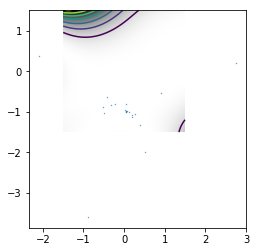

In [364]:
all_points = np.stack(all_points)

fig, ax = plt.subplots()
ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='gray_r', extent=extent[0] + extent[1])
CS = ax.contour(X, Y, Z)
ax.scatter(all_points[:,0], all_points[:,1], s=0.1)

In [200]:
simple_simplex(goldstein_price, 2)

1000


(30.20479841974458,
 array([-0.57621105, -0.42021176]),
 [array([-0.57621105, -0.42021176]),
  array([-0.58663537, -0.40017805]),
  array([-0.59807065, -0.39853994]),
  array([-1.67461169, -0.48875483]),
  array([-0.1085432 ,  0.24485193]),
  array([-0.40998577, -0.60683166]),
  array([-0.76989692, -0.72344182]),
  array([-0.66777043, -0.61495143]),
  array([-0.20326434, -0.65295708]),
  array([-0.69638761, -0.31319127]),
  array([-0.40998577, -0.60683166]),
  array([-0.69638761, -0.31319127]),
  array([-0.40437425, -0.51783032]),
  array([-0.57793254, -0.39910718]),
  array([-0.48158623, -0.53342156]),
  array([-0.58420333, -0.46078282]),
  array([-0.54089425, -0.40673047]),
  array([-0.56578672, -0.44024547]),
  array([-0.57570557, -0.41101396]),
  array([-0.58764633, -0.41857365]),
  array([-0.57772748, -0.44780517]),
  array([-0.59807065, -0.39853994]),
  array([-0.58663537, -0.40017805]),
  array([-0.58764633, -0.41857365]),
  array([-0.58663537, -0.40017805]),
  array([-0.5876463

In [ ]:
    def run_crs(
        self,
        n_live,
        max_iter,
        max_noimprovement,
        min_llh_std,
        min_vertex_std,
        use_priors,
        use_sobol,
        seed,
    ):
        """Implementation of the CRS2 algorithm, adapted to work with spherical
        coordinates (correct centroid calculation, reflection, and mutation).
        At the moment Cartesian (standard) parameters and spherical parameters
        are assumed to have particular names (i.e., spherical coordinates start
        with "az" and "zen"). Furthermore, all Cartesian coordinates must come
        first followed by the pairs of (azimuth, zenith) spherical coordinates;
        e.g., "az_1", "zen_1", "az_2", "zen_2", etc.
        Parameters
        ----------
        n_live : int
            Number of live points
        max_iter : int
            Maximum iterations
        max_noimprovement : int
            Maximum iterations with no improvement of best point
        min_llh_std : float
            Break if stddev of llh values across all livepoints drops below
            this threshold
        min_vertex_std : mapping
            Break condition on stddev of Cartesian dimension(s) (x, y, z, and
            time). Keys are dimension names and values are the standard
            deviations for each dimension. All specified dimensions must drop
            below the specified stddevs for this break condition to be met.
        use_priors : bool
            Use priors during minimization; if `False`, priors are only used
            for sampling the initial distributions. Even if set to `True`,
            angles (azimuth and zenith) do not use priors while operating (only
            for generating the initial distribution)
        use_sobol : bool
            Use a Sobol sequence instead of numpy pseudo-random numbers. Seems
            to do slightly better (but only small differences observed in tests
            so far)
        seed : int
            Random seed
        Returns
        -------
        run_info : OrderedDict
        Notes
        -----
        CRS2 [1] is a variant of controlled random search (CRS, a global
        optimizer) with faster convergence than CRS.
        Refrences
        ---------
        .. [1] P. Kaelo, M.M. Ali, "Some variants of the controlled random
           search algorithm for global optimization," J. Optim. Theory Appl.,
           130 (2) (2006), pp. 253-264.
        """
        if use_sobol:
            from sobol import i4_sobol
        t0 = time.time()

        rand = np.random.RandomState(seed=seed)

        n_opt_params = self.n_opt_params
        # absolute minimum number of points necessary
        assert n_live > n_opt_params + 1

        # figure out which variables are Cartesian and which spherical
        opt_param_names = self.hypo_handler.opt_param_names
        cart_param_names = set(opt_param_names) & set(CART_DIMS)
        n_cart = len(cart_param_names)
        assert set(opt_param_names[:n_cart]) == cart_param_names
        n_spher_param_pairs = int((n_opt_params - n_cart) / 2)
        for sph_pair_idx in range(n_spher_param_pairs):
            az_param = opt_param_names[n_cart + sph_pair_idx * 2]
            zen_param = opt_param_names[n_cart + sph_pair_idx * 2 + 1]
            assert "az" in az_param, '"{}" not azimuth param'.format(az_param)
            assert "zen" in zen_param, '"{}" not zenith param'.format(zen_param)

        for dim in min_vertex_std.keys():
            if dim not in opt_param_names:
                raise ValueError('dim "{}" not being optimized'.format(dim))
            if dim not in cart_param_names:
                raise NotImplementedError(
                    'dim "{}" stddev not computed, as stddev currently only'
                    " computed for Cartesian parameters".format(dim)
                )

        # set standard reordering so subsequent calls with different input
        # ordering will create identical metadata
        min_vertex_std = OrderedDict(
            [(d, min_vertex_std[d]) for d in opt_param_names if d in min_vertex_std]
        )

        # storage for info about stddev, whether met, and when met
        vertex_std = np.full(
            shape=1,
            fill_value=np.nan,
            dtype=[(d, np.float32) for d in min_vertex_std.keys()],
        )
        vertex_std_met = OrderedDict([(d, False) for d in min_vertex_std.keys()])
        vertex_std_met_at_iter = np.full(
            shape=1, fill_value=-1, dtype=[(d, np.int32) for d in min_vertex_std.keys()]
        )

        # Record kwargs user supplied (after translation & standardization)
        kwargs = OrderedDict()
        for arg_name in get_arg_names(self.run_crs)[1:]:
            kwargs[arg_name] = locals()[arg_name]

        # setup arrays to store points
        s_cart = np.zeros(shape=(n_live, n_cart))
        s_spher = np.zeros(shape=(n_live, n_spher_param_pairs), dtype=SPHER_T)
        llh = np.zeros(shape=(n_live,))

        def func(x):
            """Callable for minimizer"""
            if use_priors:
                param_vals = np.zeros_like(x)
                param_vals[:n_cart] = x[:n_cart]
                self.prior(param_vals)
                param_vals[n_cart:] = x[n_cart:]
            else:
                param_vals = x
            llh = self.loglike(param_vals)
            if np.isnan(llh):
                raise ValueError("llh is nan; params are {}".format(param_vals))
            if np.any(np.isnan(param_vals)):
                raise ValueError("params are nan: {}".format(param_vals))
            return -llh

        def create_x(x_cart, x_spher):
            """Patch Cartesian and spherical coordinates into one array"""
            # TODO: make proper
            x = np.empty(shape=n_opt_params)
            x[:n_cart] = x_cart
            x[n_cart + 1 :: 2] = x_spher["zen"]
            x[n_cart::2] = x_spher["az"]
            return x

        # generate initial population
        for i in range(n_live):
            # Sobol seems to do slightly better than pseudo-random numbers
            if use_sobol:
                # Note we start at seed=1 since for n_live=1 this puts the
                # first point in the middle of the range for all params (0.5),
                # while seed=0 produces all zeros (the most extreme point
                # possible, which will bias the distribution away from more
                # likely values).
                x, _ = i4_sobol(
                    dim_num=n_opt_params,  # number of dimensions
                    seed=i + 1,  # Sobol sequence number
                )
            else:
                x = rand.uniform(0, 1, n_opt_params)

            # Apply prior xforms to `param_vals` (contents are overwritten)
            param_vals = np.copy(x)
            self.prior(param_vals)

            # Always use prior-xformed angles
            x[n_cart:] = param_vals[n_cart:]

            # Only use xformed Cart params if NOT using priors during operation
            if not use_priors:
                x[:n_cart] = param_vals[:n_cart]

            # Break up into Cartesian and spherical coordinates
            s_cart[i] = x[:n_cart]
            s_spher[i]["zen"] = x[n_cart + 1 :: 2]
            s_spher[i]["az"] = x[n_cart::2]
            fill_from_spher(s_spher[i])
            llh[i] = func(x)

        best_llh = np.min(llh)
        no_improvement_counter = -1

        # optional bookkeeping
        num_simplex_successes = 0
        num_mutation_successes = 0
        num_failures = 0
        stopping_flag = 0

        # minimizer loop
        for iter_num in range(max_iter):
            if iter_num % REPORT_AFTER == 0:
                print(
                    "simplex: %i, mutation: %i, failed: %i"
                    % (num_simplex_successes, num_mutation_successes, num_failures)
                )

            # compute value for break condition 1
            llh_std = np.std(llh)

            # compute value for break condition 3
            for dim, cond in min_vertex_std.items():
                vertex_std[dim] = std = np.std(s_cart[:, opt_param_names.index(dim)])
                vertex_std_met[dim] = met = std < cond
                if met:
                    if vertex_std_met_at_iter[dim] == -1:
                        vertex_std_met_at_iter[dim] = iter_num
                else:
                    vertex_std_met_at_iter[dim] = -1

            # break condition 1
            if llh_std < min_llh_std:
                stopping_flag = 1
                break

            # break condition 2
            if no_improvement_counter > max_noimprovement:
                stopping_flag = 2
                break

            # break condition 3
            if len(min_vertex_std) > 0 and all(vertex_std_met.values()):
                stopping_flag = 3
                break

            new_best_llh = np.min(llh)

            if new_best_llh < best_llh:
                best_llh = new_best_llh
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

            worst_idx = np.argmax(llh)
            best_idx = np.argmin(llh)

            # choose n_opt_params random points but not best
            choice = rand.choice(n_live - 1, n_opt_params, replace=False)
            choice[choice >= best_idx] += 1

            # Cartesian centroid
            centroid_cart = (
                np.sum(s_cart[choice[:-1]], axis=0) + s_cart[best_idx]
            ) / n_opt_params

            # reflect point
            new_x_cart = 2 * centroid_cart - s_cart[choice[-1]]

            # spherical centroid
            centroid_spher = np.zeros(n_spher_param_pairs, dtype=SPHER_T)
            centroid_spher["x"] = (
                np.sum(s_spher["x"][choice[:-1]], axis=0) + s_spher["x"][best_idx]
            ) / n_opt_params
            centroid_spher["y"] = (
                np.sum(s_spher["y"][choice[:-1]], axis=0) + s_spher["y"][best_idx]
            ) / n_opt_params
            centroid_spher["z"] = (
                np.sum(s_spher["z"][choice[:-1]], axis=0) + s_spher["z"][best_idx]
            ) / n_opt_params
            fill_from_cart(centroid_spher)

            # reflect point
            new_x_spher = np.zeros(n_spher_param_pairs, dtype=SPHER_T)
            reflect(s_spher[choice[-1]], centroid_spher, new_x_spher)

            if use_priors:
                outside = np.any(new_x_cart < 0) or np.any(new_x_cart > 1)
            else:
                outside = False

            if not outside:
                new_llh = func(create_x(new_x_cart, new_x_spher))

                if new_llh < llh[worst_idx]:
                    # found better point
                    s_cart[worst_idx] = new_x_cart
                    s_spher[worst_idx] = new_x_spher
                    llh[worst_idx] = new_llh
                    num_simplex_successes += 1
                    continue

            # mutation
            w = rand.uniform(0, 1, n_cart)
            new_x_cart2 = (1 + w) * s_cart[best_idx] - w * new_x_cart

            # first reflect at best point
            reflected_new_x_spher = np.zeros(n_spher_param_pairs, dtype=SPHER_T)
            reflect(new_x_spher, s_spher[best_idx], reflected_new_x_spher)

            new_x_spher2 = np.zeros_like(new_x_spher)

            # now do a combination of best and reflected point with weight w
            for dim in ("x", "y", "z"):
                w = rand.uniform(0, 1, n_spher_param_pairs)
                new_x_spher2[dim] = (1 - w) * s_spher[best_idx][
                    dim
                ] + w * reflected_new_x_spher[dim]
            fill_from_cart(new_x_spher2)

            if use_priors:
                outside = np.any(new_x_cart2 < 0) or np.any(new_x_cart2 > 1)
            else:
                outside = False

            if not outside:
                new_llh = func(create_x(new_x_cart2, new_x_spher2))

                if new_llh < llh[worst_idx]:
                    # found better point
                    s_cart[worst_idx] = new_x_cart2
                    s_spher[worst_idx] = new_x_spher2
                    llh[worst_idx] = new_llh
                    num_mutation_successes += 1
                    continue

            # if we get here no method was successful in replacing worst
            # point -> start over
            num_failures += 1

        print(CRS_STOP_FLAGS[stopping_flag])

        run_info = OrderedDict(
            [
                ("method", "run_crs"),
                ("method_description", "CRS2spherical+lm+sampling"),
                ("kwargs", kwargs),
            ]
        )
        fit_meta = OrderedDict(
            [
                ("fit_status", np.int8(FitStatus.OK)),
                ("iterations", np.uint32(iter_num)),
                ("stopping_flag", np.int8(stopping_flag)),
                ("llh_std", np.float32(llh_std)),
                ("no_improvement_counter", np.uint32(no_improvement_counter)),
                ("vertex_std", vertex_std),
                ("vertex_std_met_at_iter", vertex_std_met_at_iter),
                ("num_simplex_successes", np.uint32(num_simplex_successes)),
                ("num_mutation_successes", np.uint32(num_mutation_successes)),
                ("num_failures", np.uint32(num_failures)),
                ("run_time", np.float32(time.time() - t0)),
            ]
        )

        return run_info, fit_meta